## Requirements
- Keras
- Tensorflow
- Tensorflow tools: freeze_graph, optimize_for_inference_lib

In [1]:
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input, VGG16
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, Input, Convolution2D, MaxPooling2D, Activation, concatenate, warnings
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from keras import optimizers
from keras.models import Sequential, Model 
from keras.applications.imagenet_utils import _obtain_input_shape
from keras import backend as K
from keras.engine.topology import get_source_inputs
from keras.utils import get_file
from keras.utils import layer_utils
from keras.applications.xception import Xception
import numpy as np



Using TensorFlow backend.


## Model
As the first step, I will use classification instead of object detection (i.e. ignore the case where multiple traffic lights of different colors are present). 
SqueezeNet is recommended by [David Brailovsky](https://medium.freecodecamp.org/recognizing-traffic-lights-with-deep-learning-23dae23287cc). The following Keras SqueezeNet is adopted from [rcmalli](https://github.com/rcmalli/keras-squeezenet).

In [2]:
from keras.applications.imagenet_utils import _obtain_input_shape
from keras import backend as K
from keras.layers import Input, Convolution2D, MaxPooling2D, Activation, concatenate, Dropout, warnings
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.models import Model
from keras.engine.topology import get_source_inputs
from keras.utils import get_file
from keras.utils import layer_utils


sq1x1 = "squeeze1x1"
exp1x1 = "expand1x1"
exp3x3 = "expand3x3"
relu = "relu_"

WEIGHTS_PATH = "https://github.com/rcmalli/keras-squeezenet/releases/download/v1.0/squeezenet_weights_tf_dim_ordering_tf_kernels.h5"
WEIGHTS_PATH_NO_TOP = "https://github.com/jeremykawahara/keras-squeezenet/raw/master/weights/squeezenet_weights_tf_dim_ordering_tf_kernels_notop.h5"

# Modular function for Fire Node

def fire_module(x, fire_id, squeeze=16, expand=64):
    s_id = 'fire' + str(fire_id) + '/'

    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = 3
    
    x = Convolution2D(squeeze, (1, 1), padding='valid', name=s_id + sq1x1)(x)
    x = Activation('relu', name=s_id + relu + sq1x1)(x)

    left = Convolution2D(expand, (1, 1), padding='valid', name=s_id + exp1x1)(x)
    left = Activation('relu', name=s_id + relu + exp1x1)(left)

    right = Convolution2D(expand, (3, 3), padding='same', name=s_id + exp3x3)(x)
    right = Activation('relu', name=s_id + relu + exp3x3)(right)

    x = concatenate([left, right], axis=channel_axis, name=s_id + 'concat')
    return x


# Original SqueezeNet from paper.

def SqueezeNet(include_top=True, weights='imagenet',
               input_tensor=None, input_shape=None,
               pooling=None,
               classes=1000):
    """Instantiates the SqueezeNet architecture.
    """
    
    if weights not in {'imagenet', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `imagenet` '
                         '(pre-training on ImageNet).')

    if weights == 'imagenet' and classes != 1000:
        raise ValueError('If using `weights` as imagenet with `include_top`'
                         ' as true, `classes` should be 1000')


    input_shape = _obtain_input_shape(input_shape,
                                      default_size=227,
                                      min_size=48,
                                      data_format=K.image_data_format(),
                                      require_flatten=include_top)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor


    x = Convolution2D(64, (3, 3), strides=(2, 2), padding='valid', name='conv1')(img_input)
    x = Activation('relu', name='relu_conv1')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool1')(x)

    x = fire_module(x, fire_id=2, squeeze=16, expand=64)
    x = fire_module(x, fire_id=3, squeeze=16, expand=64)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool3')(x)

    x = fire_module(x, fire_id=4, squeeze=32, expand=128)
    x = fire_module(x, fire_id=5, squeeze=32, expand=128)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool5')(x)

    x = fire_module(x, fire_id=6, squeeze=48, expand=192)
    x = fire_module(x, fire_id=7, squeeze=48, expand=192)
    x = fire_module(x, fire_id=8, squeeze=64, expand=256)
    x = fire_module(x, fire_id=9, squeeze=64, expand=256)
    
    if include_top:
        # It's not obvious where to cut the network... 
        # Could do the 8th or 9th layer... some work recommends cutting earlier layers.
    
        x = Dropout(0.5, name='drop9')(x)

        x = Convolution2D(classes, (1, 1), padding='valid', name='conv10')(x)
        x = Activation('relu', name='relu_conv10')(x)
        x = GlobalAveragePooling2D()(x)
        x = Activation('softmax', name='loss')(x)
    else:
        if pooling == 'avg':
            x = GlobalAveragePooling2D()(x)
        elif pooling=='max':
            x = GlobalMaxPooling2D()(x)
        elif pooling==None:
            pass
        else:
            raise ValueError("Unknown argument for 'pooling'=" + pooling)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input

    model = Model(inputs, x, name='squeezenet')

    # load weights
    if weights == 'imagenet':
        if include_top:
            weights_path = get_file('squeezenet_weights_tf_dim_ordering_tf_kernels.h5',
                                    WEIGHTS_PATH,
                                    cache_subdir='models')
        else:
            weights_path = get_file('squeezenet_weights_tf_dim_ordering_tf_kernels_notop.h5',
                                    WEIGHTS_PATH_NO_TOP,
                                    cache_subdir='models')
            
        model.load_weights(weights_path)
        if K.backend() == 'theano':
            layer_utils.convert_all_kernels_in_model(model)

        if K.image_data_format() == 'channels_first':

            if K.backend() == 'tensorflow':
                warnings.warn('You are using the TensorFlow backend, yet you '
                              'are using the Theano '
                              'image data format convention '
                              '(`image_data_format="channels_first"`). '
                              'For best performance, set '
                              '`image_data_format="channels_last"` in '
                              'your Keras config '
                              'at ~/.keras/keras.json.')
    return model


## Training data
Training data is downloaded from the link on [Vatsal Srivastava's github](https://drive.google.com/file/d/0B-Eiyn-CUQtxdUZWMkFfQzdObUE/view)

In [3]:
model = SqueezeNet(weights='imagenet', include_top=False, input_shape = (300,400,3))

#Adding custom Layers 
x = model.output
x = GlobalAveragePooling2D(name='avg_pool')(x)
predictions = Dense(4, activation='softmax', name='predictions')(x)

# creating the final model 
model_final = Model(input = model.input, output = predictions)

# compile the model 
model_final.compile(loss = "categorical_crossentropy", optimizer = optimizers.SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])



/home/dhlong/anaconda3/envs/tf/lib/python3.5/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("pr..., inputs=Tensor("in...)`
  if __name__ == '__main__':


In [4]:
# Initiate the train and test generators with data Augumentation 
site = True

if site:
    train_data_dir = '/home/dhlong/github/site_imgs/train'
    validation_data_dir = '/home/dhlong/github/site_imgs/test'    
    output_dir = 'site/'
else:
    train_data_dir = '/home/dhlong/github/ros_img/train'
    validation_data_dir = '/home/dhlong/github/ros_img/test'
    output_dir = 'ros/'

img_height, img_width = 300, 400

train_datagen = ImageDataGenerator(
    horizontal_flip = True,
    fill_mode = "nearest",
    zoom_range = 0.2,
    width_shift_range = 0.2,
    height_shift_range=0.2,
    rotation_range=20)

test_datagen = ImageDataGenerator(
    horizontal_flip = True,
    fill_mode = "nearest",
    zoom_range = 0.05,
    width_shift_range = 0.05,
    height_shift_range=0.05,
    rotation_range=5)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size = (img_height, img_width),
    batch_size = 8, 
    class_mode = "categorical")

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size = (img_height, img_width),
    batch_size = 8,
    class_mode = "categorical")

# Save the model according to the conditions  
checkpoint = ModelCheckpoint("sqznet.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=10, verbose=1, mode='auto')


# Train the model 
model_final.fit_generator(
    train_generator,
    steps_per_epoch = 128,
    epochs = 30,
    validation_data = validation_generator,
    validation_steps = 100)


Found 1362 images belonging to 4 classes.
Found 781 images belonging to 4 classes.
Epoch 1/30
128/128 [==============================] - 48s - loss: 1.3342 - acc: 0.5010 - val_loss: 0.4836 - val_acc: 0.8331
Epoch 2/30
128/128 [==============================] - 46s - loss: 0.4863 - acc: 0.8144 - val_loss: 0.1912 - val_acc: 0.9423
Epoch 3/30
128/128 [==============================] - 46s - loss: 0.2324 - acc: 0.9150 - val_loss: 0.0935 - val_acc: 0.9787
Epoch 4/30
128/128 [==============================] - 46s - loss: 0.1531 - acc: 0.9492 - val_loss: 0.0348 - val_acc: 0.9950
Epoch 5/30
128/128 [==============================] - 46s - loss: 0.0915 - acc: 0.9717 - val_loss: 0.0251 - val_acc: 0.9937
Epoch 6/30
128/128 [==============================] - 46s - loss: 0.0852 - acc: 0.9736 - val_loss: 0.0309 - val_acc: 0.9937
Epoch 7/30
128/128 [==============================] - 46s - loss: 0.0861 - acc: 0.9746 - val_loss: 0.0363 - val_acc: 0.9925
Epoch 8/30
128/128 [=============================

In [5]:
import tensorflow as tf

sess = K.get_session()
gd = sess.graph.as_graph_def()
saver = tf.train.Saver()
tf.train.write_graph(gd, '.', output_dir + 'model.pb', as_text=True)
saver.save(sess, output_dir + 'model.ckpt')

'site/model.ckpt'

In [6]:
y_true = []
y_hat = []

x_val = []

for i in range(100):
    x,y = validation_generator.next()
    y_true += list(np.argmax(y, axis=1))
    y_hat += list(np.argmax(model_final.predict(x), axis=1))
    x_val += list(x)

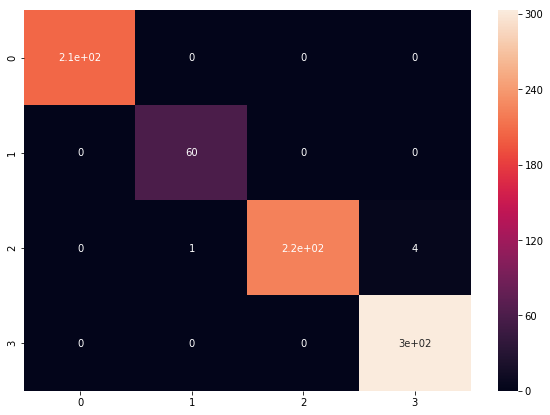

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sbn
cm = confusion_matrix(y_true, y_hat)
plt.figure(figsize = (10,7))
sbn.heatmap(cm, annot=True)

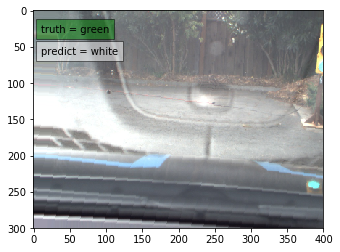

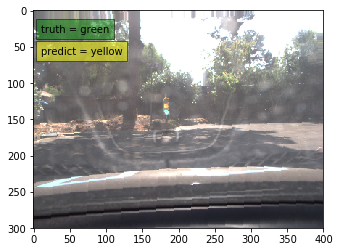

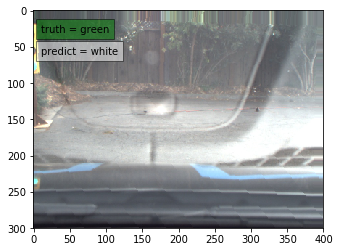

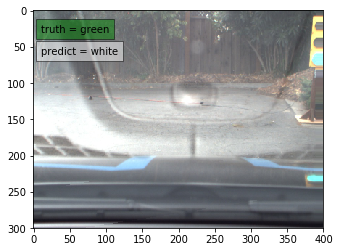

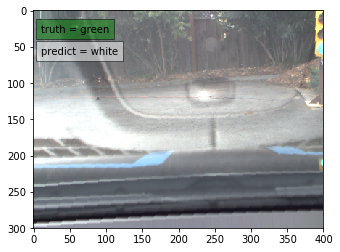

In [8]:
index = np.where(np.array(y_true) != np.array(y_hat))

%matplotlib inline
import matplotlib.pyplot as plt
for i in index[0][:20]:
    fig = plt.figure()
    plt.imshow(x_val[i]/255)
    true_color = {0:'red', 1:'yellow', 2:'green', 3:'white'}[y_true[i]]
    pred_color = {0:'red', 1:'yellow', 2:'green', 3:'white'}[y_hat[i]]
    plt.text(10, 30, 'truth = ' + true_color, bbox={'facecolor': true_color, 'alpha':0.5, 'pad':5})
    plt.text(10, 60, 'predict = ' + pred_color, bbox={'facecolor': pred_color, 'alpha':0.5, 'pad':5})



In [9]:
from tensorflow.python.tools import freeze_graph
from tensorflow.python.tools import optimize_for_inference_lib

savefolder = '.'
input_graph_path = output_dir + 'model.pb'
checkpoint_path = output_dir + 'model.ckpt'
input_saver_def_path = ""
input_binary = False
output_node_names = predictions.name.split(':')[0]
restore_op_name = "save/restore_all" # deprecated, unused
filename_tensor_name = "save/Const:0" # deprecated, unused
output_frozen_graph_name = output_dir + 'frozen_graph.pb'
output_optimized_graph_name = output_dir + 'optimized_graph.pb'
clear_devices = True


freeze_graph.freeze_graph(input_graph_path, input_saver_def_path,
                          input_binary, checkpoint_path, output_node_names,
                          restore_op_name, filename_tensor_name,
                          output_frozen_graph_name, clear_devices, "")

                                                                                                                                                                                                                                                                                                                            
# Optimize for inference

input_graph_def = tf.GraphDef()
with tf.gfile.Open(output_frozen_graph_name, "rb") as f:
    data = f.read()
    input_graph_def.ParseFromString(data)

output_graph_def = optimize_for_inference_lib.optimize_for_inference(
        input_graph_def,
        [model.input.name.split(':')[0]], # an array of the input node(s)
        [predictions.name.split(':')[0]], # an array of output nodes
        tf.float32.as_datatype_enum)

# Save the optimized graph
tf.train.write_graph(output_graph_def, savefolder, output_optimized_graph_name, as_text=False)



INFO:tensorflow:Restoring parameters from site/model.ckpt
INFO:tensorflow:Froze 52 variables.
Converted 52 variables to const ops.
204 ops in the final graph.


'./site/optimized_graph.pb'

In [10]:
input_name = model.input.name
output_name = predictions.name
io_name = {'input_name': input_name, 'output_name': output_name}
import json
with open('tensor_name.json', 'w') as f:
    json.dump(io_name, f, indent=2)

In [11]:
io_name

{'input_name': 'input_1:0', 'output_name': 'predictions/Softmax:0'}